# Проект "Аналитика поведения пользователей мобильного приложения и анализ результатов А/А/В-теста"

## Содержание

##### Часть 1. Введение
* [1.1 Цель проекта](#section_1.1)
* [1.2 Набор данных для анализа](#section_1.2)

##### Часть 2. Ознакомление с данными и предобработка
* [2.1 Загрузка библиотек и ознакомление с данными](#section_2.1)
* [2.2 Предобработка данных](#section_2.2)
* [2.3 Проверка и очистка данных](#section_2.3)
* [2.4 Вывод](#section_2.4)

##### Часть 3. Анализ поведения пользователей
* [3.1 Воронка событий](#section_3.1)
* [3.2 Вывод](#section_3.2)

##### Часть 4. Анализ результатов А/А/В-теста
* [4.1 Функция для сравнения](#section_4.1)
* [4.2 Сравнение контрольных групп](#section_4.2)
* [4.3 Сравнение экспериментальной группы с контрольными](#section_4.3)
* [4.4 Применение поправки Холма-Бонферрони для множественных сравнений](#section_4.4)
* [4.5 Вывод](#section_4.5)

## Часть 1. Введение

<a id='section_1.1'></a>
### 1.1 Цель проекта

В рамках данного проекта мы изучим данные о поведении пользователей мобильного приложения стартапа, который продаёт продукты питания.

Сначала мы планируем построить воронку продаж и посмотреть, какая часть пользователей переходит на каждый последующий этап.

Далее мы планируем проанализировать результаты A/A/B-эксперимента. В ходе эксперимента две контрольные группы видели наше приложение в текущем виде, а экспериментальная группа - с измененными шрифтами. По результатам анализа мы сделаем рекомендации о желательности / нежелательности замены шрифтов, которую предложили наши дизайнеры

<a id='section_1.2'></a>
### 1.2 Набор данных

У нас имеется набор данных, в котором содержится следующая информация:
 - название события;
 - уникальный идентификатор пользователя;
 - время события;
 - номер эксперимента, в котором выделены две контрольные группы (246 и 247) и одна экспериментальная (248).

## Часть 2. Озакомление с данными и предобработка

<a id='section_2.1'></a>
### 2.1 Загрузка библиотек и ознакомление с данными

Загрузим необходимые библиотеки и изучим имеющиеся данные.

In [56]:
# Загружаем необходимые библиотеки
import pandas as pd
import numpy as np
from scipy import stats as st
import math as mth

from matplotlib import pyplot as plt
from plotly import graph_objects as go

import warnings
warnings.filterwarnings('ignore')

In [57]:
# Загружаем данные и смотрим первые 10 строк
raw_data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
raw_data.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [58]:
# Смотрим полноту данных и типы данных
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


После первого изучения данных мы видим, что в столбце с временем события данные имеют неподходящий тип - исправим в дальнейшем. 

<a id='section_2.2'></a>
### 2.2 Предобработка данных

Подготовим данные для дальнейшей работы.

In [59]:
# Заменяем названия столбцов
raw_data.columns = ['event', 'user_id', 'timestamp', 'exp_id']

In [60]:
# Выполняем проверку на наличие дубликатов
raw_data.duplicated().sum()

413

In [61]:
raw_data.duplicated().sum() / len(raw_data)

0.0016917493425526163

In [62]:
# Удаляем дубликаты
raw_data.drop_duplicates(inplace=True)

In [63]:
# Добавляем столбец с датой и временем
raw_data['datetime'] = pd.to_datetime(raw_data['timestamp'], unit='s')

# Добавляем отдельный столбец с датой и задаем ему нужный тип 
raw_data['date'] = raw_data['datetime'].dt.date
raw_data['date'] = pd.to_datetime(raw_data['date'])
raw_data.head(5)

,event,user_id,timestamp,exp_id,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [64]:
# Проверяем, все ли ок
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
event        243713 non-null object
user_id      243713 non-null int64
timestamp    243713 non-null int64
exp_id       243713 non-null int64
datetime     243713 non-null datetime64[ns]
date         243713 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 13.0+ MB


<a id='section_2.3'></a>
### 2.3 Проверка и очистка данных

Изучим более детально имеющиеся данные, чтобы удостовериться в их корректности. При необходимости очистим датасет от лишних данных.

In [65]:
# Смотрим, какие уникальные события содержатся в логе
raw_data['event'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [66]:
# Сколько уникальных пользователей
raw_data['user_id'].nunique()

7551

In [67]:
# Сколько примерно событий приходится на одного пользователя
len(raw_data) / raw_data['user_id'].nunique()

32.27559263673685

In [68]:
# Смотрим информацию, о периоде данных в логе
raw_data['datetime'].describe()

count                  243713
unique                 176654
top       2019-08-01 14:40:35
freq                        9
first     2019-07-25 04:43:36
last      2019-08-07 21:15:17
Name: datetime, dtype: object

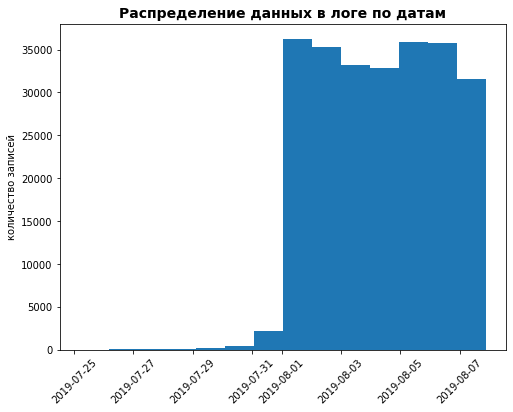

In [69]:
# Посмотрим на распределение записей по датам
plt.figure(figsize=(8, 6))
raw_data['datetime'].hist(bins=14, grid=False)
plt.xticks(rotation=45)
plt.ylabel('количество записей')
plt.title('Распределение данных в логе по датам', fontsize=14, fontweight='bold')
plt.show()

Видим, что количество записей о событиях до 1 августа существенно меньше, чем количество записей о событиях в период с 1 по 7 августа. Поэтому удалим записи о событиях до 1 августа.

In [70]:
# Выбираем записи, начиная с 1 августа, и проверяем
data = raw_data[raw_data['date'] > '2019-07-31']
data['date'].describe()

count                  240887
unique                      7
top       2019-08-01 00:00:00
freq                    36141
first     2019-08-01 00:00:00
last      2019-08-07 00:00:00
Name: date, dtype: object

In [71]:
# Смотрим, какое количество данных мы потеряли
print("Количество событий уменьшилось на {} событий, что составляет {:.1%} от первоначального числа."
      .format(len(raw_data) - len(data), (len(raw_data) - len(data)) / len(raw_data))) 
print("Количество уникальных пользователей уменьшилось на {}, что составляет {:.1%} от первоначального числа."
      .format(raw_data['user_id'].nunique() - data['user_id'].nunique(), 
              (raw_data['user_id'].nunique() - data['user_id'].nunique()) / raw_data['user_id'].nunique())) 

Количество событий уменьшилось на 2826 событий, что составляет 1.2% от первоначального числа.
Количество уникальных пользователей уменьшилось на 17, что составляет 0.2% от первоначального числа.


Проверим, что в наборе данных содержатся записи по всем трём экспериментальным группам.

In [72]:
print(f"Количество пользователей из контрольной группы 246: {data.query('exp_id == 246')['user_id'].nunique()}.")
print(f"Количество пользователей из контрольной группы 247: {data.query('exp_id == 247')['user_id'].nunique()}.")
print(f"Количество пользователей из экспериментальной группы 248: {data.query('exp_id == 248')['user_id'].nunique()}.")

Количество пользователей из контрольной группы 246: 2484.
Количество пользователей из контрольной группы 247: 2513.
Количество пользователей из экспериментальной группы 248: 2537.


In [73]:
# Выделяем уникальных пользователей каждой группы
users_246 = pd.Series(data.query('exp_id == 246')['user_id'].unique())
users_247 = pd.Series(data.query('exp_id == 247')['user_id'].unique())
users_248 = pd.Series(data.query('exp_id == 248')['user_id'].unique())
# Объединяем в единый series
all_users = pd.concat([users_246, users_247, users_248])

In [74]:
# Проверяем на наличие дубликатов
all_users.duplicated().sum()

0

<a id='section_2.4'></a>
### 2.4 Вывод

1. В первоначальном наборе содержались записи о 244126 событиях в период с 25 июля по 7 августа 2019 года. В данных не было пропусков, но они содержали 0,17% дубликатов, которые мы удалили.
2. Данные были неравномерно распределены по датам - количество событий за июль было незначительным по сравнению с августом. Мы удалили эти записи, оставив только данные за те дни, где они могли считаться полными. При этом мы потеряли еще примерно 1,2% от общего числа записей и 0,2% от количества уникальных пользователей. 
3. В очищенном датасете пользователи равномерно распределены по трем группам. При этом записи о каждом уникальном пользователе относятся лишь к одной группе.

## Часть 3. Анализ поведения пользователей

<a id='section_3.1'></a>
### 3.1 Воронка событий

Построим воронку событий и изучим, какое количество пользователей переходит на каждый последующий этап, на каких этапах мы теряем больше всего пользователей.

In [75]:
# Группируем данные по названию события и считаем количество событий
events_funnel = data.groupby('event').agg({'user_id': 'count'}).sort_values(by='user_id', ascending=False).reset_index()
events_funnel.columns = ['event', 'events_count']
events_funnel

,event,events_count
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


Мы видим, что чаще всего у нас фиксируется событие "Показ главной страницы". Затем следует "Показ страницы с товаром", "Показ корзины с покупками", "Страница завершения оплаты" и "Знакомство с приложением". Первые четыре события выстроены в правильной последовательности, последнее же событие не является частью воронки (не все пользователи проходят данный этап; пользователи могут обратиться к данному этапу в любой момент), поэтому удалим данные о таких событиях из набора данных и посмотрим распределение событий по количеству уникальных пользователей.

In [76]:
# Удаляем записи с событием Tutorial
data_clean = data.query('event != "Tutorial"')

In [77]:
# Группируем данные по событию и считаем количество уникальных пользователей
users_funnel = data_clean.groupby('event').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False).reset_index()
users_funnel.columns = ['event', 'users_count']
# Считаем процент пользователей от общего количества уникальных пользователей, переходящих на следующий этап 
users_funnel['event_users_to_all_users_ratio'] = (users_funnel['users_count'] / data['user_id'].nunique()).round(2)
users_funnel

,event,users_count,event_users_to_all_users_ratio
0,MainScreenAppear,7419,0.98
1,OffersScreenAppear,4593,0.61
2,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.47


Мы рассчитали долю пользователей от общего числа уникальных пользователей, которые хоть раз совершали каждое из событий.

Дополним таблицу данными о доле пользователей, которая проходит на следующий шаг воронки от числа пользователей на предыдущем. 

In [78]:
# Дополним таблицу столбцом с количеством ползователей на предыдущем шаге 
users_funnel['prev_step_users'] = (users_funnel['users_count'].shift(periods=1)).astype(pd.Int32Dtype())
users_funnel['prev_step_users'] = users_funnel['prev_step_users'].fillna(7419)
# Считаем соотношение пользователей на текущем шаге к количеству пользователей на предыдущем шаге 
users_funnel['event_users_to_prev_step_users_ratio'] = (users_funnel['users_count'] / users_funnel['prev_step_users']).round(2)
users_funnel

,event,users_count,event_users_to_all_users_ratio,prev_step_users,event_users_to_prev_step_users_ratio
0,MainScreenAppear,7419,0.98,7419,1.00
1,OffersScreenAppear,4593,0.61,7419,0.62
2,CartScreenAppear,3734,0.50,4593,0.81
3,PaymentScreenSuccessful,3539,0.47,3734,0.95


In [80]:
# Визуализируем воронку
fig = go.Figure(go.Funnel(y=users_funnel['event'], x=users_funnel['users_count']))
fig.update_layout(title={'text': "Воронка событий по количеству уникальных пользователей", 
                         'y':0.9, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'}, 
                  font=dict(size=14))
fig.show()

На интерактивной воронке видим количество пользователей, переходящих на следующий этап, по отношению к первоначальному количеству пользователей (на первом этапе) и по отношению к предыдущему этапу. 

Мы видим, что больше всего пользователей - почти 38% от первоначального количества - теряем при переходе с первого на второй этап - то есть пользователи, просмотрев главную страницу, не переходят на страницу с товарами. При переходе со второго на третий и с третьего на четверый этап теряется всего 14% от первоначального количества. До оплаты доходят более 47% пользователей от первоначального количества пользователей. 

<a id='section_3.2'></a>
### 3.2 Вывод

1. Наша воронка событий выглядит следующим образом:
   - Показ главной страницы,
   - Показ страницы с товаром,
   - Показ корзины с покупками,
   - Страница завершения оплаты.
2. В данных также содержалась информация о событии "Знакомство с приложением", которое не является частью воронки, поэтому мы удалили записи о таких событиях из набора данных. 
3. Больше всего пользователей - почти 38% от первоначального количества - теряется при переходе с первого на второй этап. При переходе со второго на третий и с третьего на четверый этап теряется всего 14%. До оплаты доходят более 47% пользователей. 
4. Причины большого отсева пользователей при переходе с первого на второй этап требуют более глубокого изучения.

## Часть 4. Анализ результатов А/А/В-теста

<a id='section_4.1'></a>
### 4.1 Подготовка выборок и написание функции

Проверим, сколько пользователей входит в каждую группу эксперимента. Для этого сначала сделаем отдельный срез данных по каждой группе и общий по объединенной контрольной.

In [81]:
# Отберем данные по каждой группе в отдельный датасет
data_246 = data_clean.query('exp_id == 246')
data_247 = data_clean.query('exp_id == 247')
data_248 = data_clean.query('exp_id == 248')
data_246_247 = data_clean.query('exp_id == 246 or exp_id == 247')

In [82]:
# Посмотрим, сколько пользователей и какой процент от общего числа относится к каждой группе
print("Количество пользователей в контрольной группе 246 составляет {}; это {:.1%} от общего числа пользователей."
      .format(data_246['user_id'].nunique(), data_246['user_id'].nunique() / data_clean['user_id'].nunique()))
print("Количество пользователей в контрольной группе 247 составляет {}; это {:.1%} от общего числа пользователей."
      .format(data_247['user_id'].nunique(), data_247['user_id'].nunique() / data_clean['user_id'].nunique()))
print("Количество пользователей в экспериментальной группе 248 составляет {}; это {:.1%} от общего числа пользователей."
      .format(data_248['user_id'].nunique(), data_248['user_id'].nunique() / data_clean['user_id'].nunique()))

Количество пользователей в контрольной группе 246 составляет 2483; это 33.0% от общего числа пользователей.
Количество пользователей в контрольной группе 247 составляет 2512; это 33.4% от общего числа пользователей.
Количество пользователей в экспериментальной группе 248 составляет 2535; это 33.7% от общего числа пользователей.


Разница в размерах групп колеблется в пределах 0,7%, что допустимо.

Далее мы планируем проверить наличие статистически значимых различий между выборками различных групп эксперимента. Для проверки будем использовать z-тест.

Так как мы будем проводить целый ряд попарных сравнений, напишем функцию, чтобы оптимизировать данный процесс.

In [83]:
# Создадим переменную, в которую будем сохранять все р-значения
ALL_P_VALUES = []

# Напишем функцию для проверки наличия стат. значимых отличий
def stat_difference_check(alpha, dataset1, dataset2, event_name):

    # Выделим названия групп
    group1 = dataset1['exp_id'].unique()
    group2 = dataset2['exp_id'].unique()
    
    # Сформулируем нулевую гипотезу
    print('Гипотеза:')
    print('H0: Конверсия в событие {} для групп {} и {} одинакова.'.format(event_name, group1, group2))
    print('H1: Конверсия в событие {} для групп {} и {} имеет статистически значимое различие.'
          .format(event_name, group1, group2))
    print()
    
    # Установим критический уровень статистической значимости
    alpha = alpha 

    # Выделим количество уникальных пользователей в группе 1, у которых наступило событие
    event_users_g1 = dataset1.query('event == @event_name')['user_id'].nunique()
    # Выделим общее количество уникальных пользователей в группе 1
    total_users_g1 = dataset1['user_id'].nunique()

    # Выделим количество уникальных пользователей в группе 2, у которых наступило событие
    event_users_g2 = dataset2.query('event == @event_name')['user_id'].nunique()
    # Выделим общее количество уникальных пользователей в группе 1
    total_users_g2 = dataset2['user_id'].nunique()

    # Посчитаем пропорцию успехов в группе 1 и группе 2 и выведем на экран 
    p1 = event_users_g1 / total_users_g1
    p2 = event_users_g2 / total_users_g2
    print('Результат сравнения:')
    print('Соотношение пользователей, у которых произошло событие {}, к общему числу пользователей:'.format(event_name))
    print('группа {} - {:.2%};'.format(group1, p1))
    print('группа {} - {:.2%}.'.format(group2, p2))
   
    # Посчитаем общую пропорцию успехов
    p_combined = (event_users_g1 + event_users_g2) / (total_users_g1 + total_users_g2)

    # Считаем разницу пропорций в датасетах
    difference = p1 - p2 

    # Считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total_users_g1 + 1/total_users_g2))

    # Задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    # Считаем p-значение
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    # Добавим полученное р-значение в переменную ALL_P_VALUES
    ALL_P_VALUES.append(p_value)

    # Выводим полученное р-значение и вывод о результате проведенного сравнения
    print('P-значение:', p_value)
    print()
    
    if (p_value < alpha):
        print('Вывод:')
        print('Отвергаем нулевую гипотезу - между долями есть значимая разница.')
    else:
        print('Вывод:')
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.') 

<a id='section_4.2'></a>
### 4.2 Сравнение контрольных групп

В нашем тесте пользователи разделены на три группы: 2 контрольные и 1 экспериментальную. Наличие двух контрольных групп вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, мы можем быть уверены в точности проведенного тестирования. Если же между значениями контрольных групп будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. 

Проведем сравнение долей пользователей, совершивших каждое событие в воронке, между контрольными группами 246 и 247, используя подготовленную функцию. Установим уровень значимость равным 0,05.

In [84]:
# Используем функцию, установив уровень стат. значимости 0,05
stat_difference_check(.05, data_246, data_247, "MainScreenAppear")

Гипотеза:
H0: Конверсия в событие MainScreenAppear для групп [246] и [247] одинакова.
H1: Конверсия в событие MainScreenAppear для групп [246] и [247] имеет статистически значимое различие.

Результат сравнения:
Соотношение пользователей, у которых произошло событие MainScreenAppear, к общему числу пользователей:
группа [246] - 98.67%;
группа [247] - 98.57%.
P-значение: 0.7526703436483038

Вывод:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


In [85]:
# Используем функцию, установив уровень стат. значимости 0,05
stat_difference_check(.05, data_246, data_247, "OffersScreenAppear")

Гипотеза:
H0: Конверсия в событие OffersScreenAppear для групп [246] и [247] одинакова.
H1: Конверсия в событие OffersScreenAppear для групп [246] и [247] имеет статистически значимое различие.

Результат сравнения:
Соотношение пользователей, у которых произошло событие OffersScreenAppear, к общему числу пользователей:
группа [246] - 62.10%;
группа [247] - 60.51%.
P-значение: 0.24786096925282264

Вывод:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


In [86]:
# Используем функцию, установив уровень стат. значимости 0,05
stat_difference_check(.05, data_246, data_247, "CartScreenAppear")

Гипотеза:
H0: Конверсия в событие CartScreenAppear для групп [246] и [247] одинакова.
H1: Конверсия в событие CartScreenAppear для групп [246] и [247] имеет статистически значимое различие.

Результат сравнения:
Соотношение пользователей, у которых произошло событие CartScreenAppear, к общему числу пользователей:
группа [246] - 50.99%;
группа [247] - 49.28%.
P-значение: 0.22867643757335676

Вывод:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


In [87]:
# Используем функцию, установив уровень стат. значимости 0,05
stat_difference_check(.05, data_246, data_247, "PaymentScreenSuccessful")

Гипотеза:
H0: Конверсия в событие PaymentScreenSuccessful для групп [246] и [247] одинакова.
H1: Конверсия в событие PaymentScreenSuccessful для групп [246] и [247] имеет статистически значимое различие.

Результат сравнения:
Соотношение пользователей, у которых произошло событие PaymentScreenSuccessful, к общему числу пользователей:
группа [246] - 48.33%;
группа [247] - 46.10%.
P-значение: 0.11446627829276612

Вывод:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


**Вывод:**
Z-тест не выявил статистически значимых различий в долях пользователей групп 246 и 247 на каждом уровне воронки, что в свою очередь подтверждает, что контрольные группы были отобраны корректно.

<a id='section_4.3'></a>
### 4.3 Сравнение экспериментальной группы с контрольными

Теперь аналогичным образом сравним результаты экспериментальной группы 248 (пользователи которой видели страницу с измененными шрифтами) с каждой из контрольных групп в отдельности по каждому событию.

In [88]:
# Используем функцию, установив уровень стат. значимости 0,05
stat_difference_check(.05, data_246, data_248, "MainScreenAppear")

Гипотеза:
H0: Конверсия в событие MainScreenAppear для групп [246] и [248] одинакова.
H1: Конверсия в событие MainScreenAppear для групп [246] и [248] имеет статистически значимое различие.

Результат сравнения:
Соотношение пользователей, у которых произошло событие MainScreenAppear, к общему числу пользователей:
группа [246] - 98.67%;
группа [248] - 98.34%.
P-значение: 0.3387114076159288

Вывод:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


In [89]:
# Используем функцию, установив уровень стат. значимости 0,05
stat_difference_check(.05, data_247, data_248, "MainScreenAppear")

Гипотеза:
H0: Конверсия в событие MainScreenAppear для групп [247] и [248] одинакова.
H1: Конверсия в событие MainScreenAppear для групп [247] и [248] имеет статистически значимое различие.

Результат сравнения:
Соотношение пользователей, у которых произошло событие MainScreenAppear, к общему числу пользователей:
группа [247] - 98.57%;
группа [248] - 98.34%.
P-значение: 0.5194964354051703

Вывод:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


In [90]:
# Используем функцию, установив уровень стат. значимости 0,05
stat_difference_check(.05, data_246, data_248, "OffersScreenAppear")

Гипотеза:
H0: Конверсия в событие OffersScreenAppear для групп [246] и [248] одинакова.
H1: Конверсия в событие OffersScreenAppear для групп [246] и [248] имеет статистически значимое различие.

Результат сравнения:
Соотношение пользователей, у которых произошло событие OffersScreenAppear, к общему числу пользователей:
группа [246] - 62.10%;
группа [248] - 60.39%.
P-значение: 0.21442476639710506

Вывод:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


In [91]:
# Используем функцию, установив уровень стат. значимости 0,05
stat_difference_check(.05, data_247, data_248, "OffersScreenAppear")

Гипотеза:
H0: Конверсия в событие OffersScreenAppear для групп [247] и [248] одинакова.
H1: Конверсия в событие OffersScreenAppear для групп [247] и [248] имеет статистически значимое различие.

Результат сравнения:
Соотношение пользователей, у которых произошло событие OffersScreenAppear, к общему числу пользователей:
группа [247] - 60.51%;
группа [248] - 60.39%.
P-значение: 0.9333751305879443

Вывод:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


In [92]:
# Используем функцию, установив уровень стат. значимости 0,05
stat_difference_check(.05, data_246, data_248, "CartScreenAppear")

Гипотеза:
H0: Конверсия в событие CartScreenAppear для групп [246] и [248] одинакова.
H1: Конверсия в событие CartScreenAppear для групп [246] и [248] имеет статистически значимое различие.

Результат сравнения:
Соотношение пользователей, у которых произошло событие CartScreenAppear, к общему числу пользователей:
группа [246] - 50.99%;
группа [248] - 48.52%.
P-значение: 0.08067367598823139

Вывод:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


In [93]:
# Используем функцию, установив уровень стат. значимости 0,05
stat_difference_check(.05, data_247, data_248, "CartScreenAppear")

Гипотеза:
H0: Конверсия в событие CartScreenAppear для групп [247] и [248] одинакова.
H1: Конверсия в событие CartScreenAppear для групп [247] и [248] имеет статистически значимое различие.

Результат сравнения:
Соотношение пользователей, у которых произошло событие CartScreenAppear, к общему числу пользователей:
группа [247] - 49.28%;
группа [248] - 48.52%.
P-значение: 0.5878284605111943

Вывод:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


In [94]:
# Используем функцию, установив уровень стат. значимости 0,05
stat_difference_check(.05, data_246, data_248, "PaymentScreenSuccessful")

Гипотеза:
H0: Конверсия в событие PaymentScreenSuccessful для групп [246] и [248] одинакова.
H1: Конверсия в событие PaymentScreenSuccessful для групп [246] и [248] имеет статистически значимое различие.

Результат сравнения:
Соотношение пользователей, у которых произошло событие PaymentScreenSuccessful, к общему числу пользователей:
группа [246] - 48.33%;
группа [248] - 46.59%.
P-значение: 0.21693033984516674

Вывод:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


In [95]:
# Используем функцию, установив уровень стат. значимости 0,05
stat_difference_check(.05, data_247, data_248, "PaymentScreenSuccessful")

Гипотеза:
H0: Конверсия в событие PaymentScreenSuccessful для групп [247] и [248] одинакова.
H1: Конверсия в событие PaymentScreenSuccessful для групп [247] и [248] имеет статистически значимое различие.

Результат сравнения:
Соотношение пользователей, у которых произошло событие PaymentScreenSuccessful, к общему числу пользователей:
группа [247] - 46.10%;
группа [248] - 46.59%.
P-значение: 0.7275718682261119

Вывод:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


**Вывод:**
По результатам сравнения долей пользователей, совершивших события, в каждой из контрольных групп с экспериментальной группой не удалось выявить статистически значимых различий. Таким образом, можно считать, что замена шрифтов не повлияла на конверсию в любое из событий воронки. 

Дополнительно сравним результаты экспериментальной группы с объединённой контрольной группой.

In [96]:
# Используем функцию, установив уровень стат. значимости 0,05
stat_difference_check(.05, data_246_247, data_248, "MainScreenAppear")

Гипотеза:
H0: Конверсия в событие MainScreenAppear для групп [246 247] и [248] одинакова.
H1: Конверсия в событие MainScreenAppear для групп [246 247] и [248] имеет статистически значимое различие.

Результат сравнения:
Соотношение пользователей, у которых произошло событие MainScreenAppear, к общему числу пользователей:
группа [246 247] - 98.62%;
группа [248] - 98.34%.
P-значение: 0.3486684291093256

Вывод:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


In [97]:
# Используем функцию, установив уровень стат. значимости 0,05
stat_difference_check(.05, data_246_247, data_248, "OffersScreenAppear")

Гипотеза:
H0: Конверсия в событие OffersScreenAppear для групп [246 247] и [248] одинакова.
H1: Конверсия в событие OffersScreenAppear для групп [246 247] и [248] имеет статистически значимое различие.

Результат сравнения:
Соотношение пользователей, у которых произошло событие OffersScreenAppear, к общему числу пользователей:
группа [246 247] - 61.30%;
группа [248] - 60.39%.
P-значение: 0.44582745409482394

Вывод:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


In [98]:
# Используем функцию, установив уровень стат. значимости 0,05
stat_difference_check(.05, data_246_247, data_248, "CartScreenAppear")

Гипотеза:
H0: Конверсия в событие CartScreenAppear для групп [246 247] и [248] одинакова.
H1: Конверсия в событие CartScreenAppear для групп [246 247] и [248] имеет статистически значимое различие.

Результат сравнения:
Соотношение пользователей, у которых произошло событие CartScreenAppear, к общему числу пользователей:
группа [246 247] - 50.13%;
группа [248] - 48.52%.
P-значение: 0.18683558686831558

Вывод:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


In [99]:
# Используем функцию, установив уровень стат. значимости 0,05
stat_difference_check(.05, data_246_247, data_248, "PaymentScreenSuccessful")

Гипотеза:
H0: Конверсия в событие PaymentScreenSuccessful для групп [246 247] и [248] одинакова.
H1: Конверсия в событие PaymentScreenSuccessful для групп [246 247] и [248] имеет статистически значимое различие.

Результат сравнения:
Соотношение пользователей, у которых произошло событие PaymentScreenSuccessful, к общему числу пользователей:
группа [246 247] - 47.21%;
группа [248] - 46.59%.
P-значение: 0.6107918742187335

Вывод:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


**Вывод:**
Сравнение объединенной контрольной группы с экспериментальной группой не выявило статистически значимых различий ни на одном уровне, что подтверждает ранее сделаные выводы.

<a id='section_4.4'></a>
### 4.4 Применение поправки Холма-Бонферрони для множественных сравнений

Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

В целом мы провели 16 тестов, используя один набор данных. 

Известно, что при одновременной проверке большого числа гипотез на одном наборе данных вероятность сделать неверное заключение в отношении хотя бы одной из этих гипотез значительно превышает изначально принятый уровень значимости.

Для того, чтобы минимизировать число ложных отклонений верных гипотез, можно использовать метод Холма, который представляет собой гораздно более мощную модификацию подхода, предложенного Бонферрони.

Модифицированный метод основан на алгоритме, который включает следующие шаги:
- Исходные Р-значения упорядочиваются по возрастанию (эти Р-значения соответствуют проверяемым гипотезам).
- Если минимальное р-значение больше уровня значимости, деленного на количество проведенных тестов, все нулевые гипотезы принимаются и процедура останавливается. 
- Иначе следует отвергнуть гипотезу, при проверке которой было получено минимальное р-значение и продолжить.
- Если следующее р-значение больше уровня значимости, деленного на количество проведенных тестов минус 1, все оставшиеся нулевые гипотезы принимаются и процедура останавливается. 
- Иначе гипотеза отвергается и процедура продолжается. При каждой последующей проверке р-значение сравнивается с уровнем значимости, деленным на количество тестов, уменьшенное на 1 по сравнению с количеством тестов в предыдущей проверке.

Применим метод Холма-Бонферрони к р-значениям, полученным в ходе проведения сравнения результатов нашего теста. Строго говоря, в случае с ранее проведенными сравнениями, ни одна из нулевых гипотез не была отвергнута, поэтому можно было не применять метод Бонферрони-Холма. Но написанный алгоритм позволит провести нам сравнения с разными уровнями значимости.

In [100]:
# Отсортируем по возрастанию список со всеми р-значениями 
ALL_P_VALUES.sort()

# Указываем уровень значимости
alpha = .05
# Указываем общее количество тестов
n_tests = 16

print(f'Уровень значимости - {alpha}.')
print('Вывод c учетом применения поправки Бонферрони-Холма:')

# Проверяем все р-значения в списке, начиная с наименьшего:
# Если минимальное р-значение больше уровня значимости, деленного на общее количество тестов,
# то принимаем все гипотезы
if ALL_P_VALUES[0] > alpha / n_tests:
    print(f'Все гипотезы приняты.')
else:
# Если минимальное р-значение меньше уровня значимости, деленного на общее количество тестов,
# то отвергаем гипотезу с данным р-значением и уменьшаем количество тестов на 1
    print(f'Гипотеза с p-значением {ALL_P_VALUES[0]} отвергнута.')
    n_tests -= 1
    for i in range(1, len(ALL_P_VALUES)):
        if ALL_P_VALUES[i] < alpha / n_tests:
            print(f'Гипотеза с p-значением {ALL_P_VALUES[i]} отвергнута.')
            n_tests -=1
# Как только доходим до гипотезы, у которой р-значение больше уровня значимости, 
# деленного на оставшееся количество тестов, принимаем все оставшиемя гипотезы и
# выходим из цикла
        else:
            print('Все последующие гипотезы приняты.')
            break

Уровень значимости - 0.05.
Вывод c учетом применения поправки Бонферрони-Холма:
Все гипотезы приняты.


**Вывод:** с учетом применения метода Холма-Бонферрони, который применяется чтобы снизить групповую вероятность ошибки первого рода и скорректировать требуемые уровни значимости, все нулевые гипотезы приняты. То есть мы не выявили статистически значимых различий между контрольными группами и между контрольными группами и экспериментальной группой.

<a id='section_4.5'></a>
### 4.5 Вывод 

В ходе А/А/В-теста были получены результаты двух контрольных и одной экспериментальной группы. Мы проверили количество пользователей, вошедших в каждую группу, и разница составила на более 0,7%.

Мы провели 16 z-тестов для сравнения долей пользователей, совершивших события, составляющие нашу воронку событий.
В ходе тестов:
1) мы не выявили статистически значимых различий между результатами двух контрольных групп - что подтверждает точность тестирования.
2) мы не выявили статистически значимых различий между результатами контрольных групп и экспериментальной группы. Это говорит, об отсутствии влияния замены шрифтов на конверсию пользователей мобильного приложения.

Для снижения группой вероятности ошибки первого рода (отвержения верной гипотезы), мы применили метод Холма-Бонферрони. При применении метода корректность сделанных ранее выводов подтвердилась.